## Sielok.hu adatok elemzése

<img src="https://sielok.hu/files/sielok-logo-feher-400x198.jpg" width="450"/>

In [1]:
import sys 
sys.path.append('../../')

from src.import_packages import *
from src.visualize_EDA import vEDA

Importing the following packages: pandas, numpy, matplotlib, seaborn, plotly, warnings


In [88]:
data = pd.read_csv('data/data.csv')
data = data[data['Felnőtt napijegy ára'] != 'A síbérlet ára naponta változikKedvezményes síbérlet']
data['Felnőtt napijegy ára'] = data['Felnőtt napijegy ára'].astype(float)
data.head(3)

,Síterep,Link,Régió,Parkoló,Hegytető,Sípályák hossza,Szintkülönbség,Liftek száma,Szezon eleje,Szezon vége,...,Felnőtt napijegy ára,Húzólift,Kombilift,Kék,Piros,Fekete,Ülőlift,Nagykabinos lift,Kiskabinos lift,Vonat
0,Abtenau im Lammertal - Karkogel,https://sielok.hu/siterep/abtenau/,Salzburg,712,1200,9.0,488,5,2022.12.30.,2023.03.26.,...,40.0,4,1,4.4,1.6,3.0,0,0,0,0
1,Achenkirch - Christlum,https://sielok.hu/siterep/achenkirch-christlum/,Tirol,950,1800,27.0,850,10,2022.12.15.,2023.04.10.,...,55.0,6,0,6.0,16.0,5.0,4,0,0,0
2,Aflenz - Bürgeralm,https://sielok.hu/siterep/aflenz/,Stájerország,810,1810,14.0,1000,7,2022.12.10.,2023.03.26.,...,37.0,6,0,2.0,10.0,2.0,1,0,0,0


In [89]:
data['Kék arány'] = data['Kék'] / data['Sípályák hossza']
data['Piros arány'] = data['Piros'] / data['Sípályák hossza']
data['Fekete arány'] = data['Fekete'] / data['Sípályák hossza']

### Vizualizációk - adatok közti kapcsolatok, eloszlások

In [90]:
vdata = vEDA(data)

#### Eloszlások

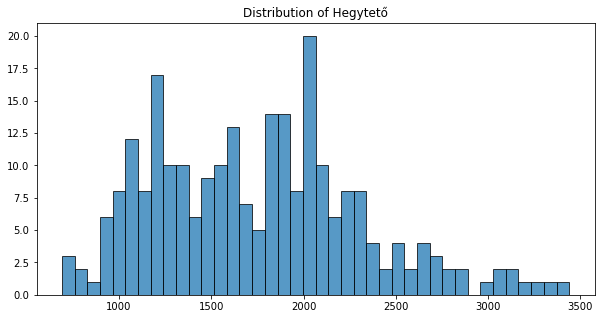

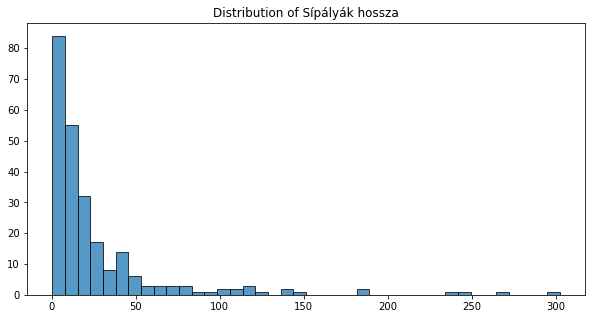

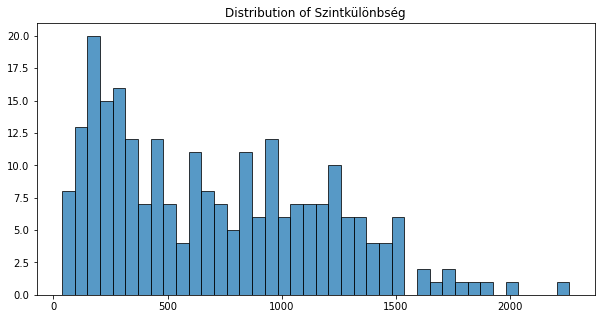

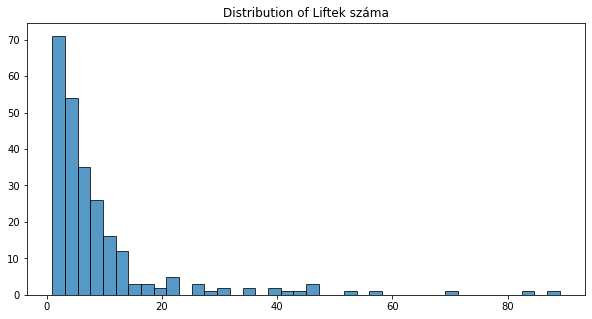

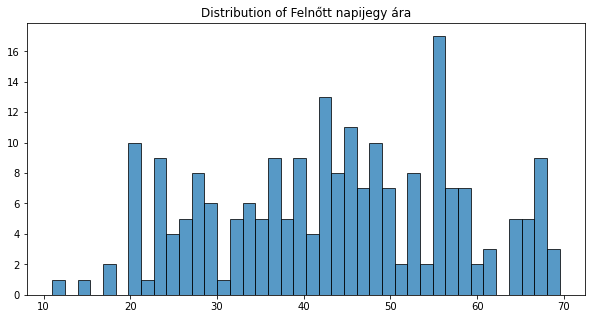

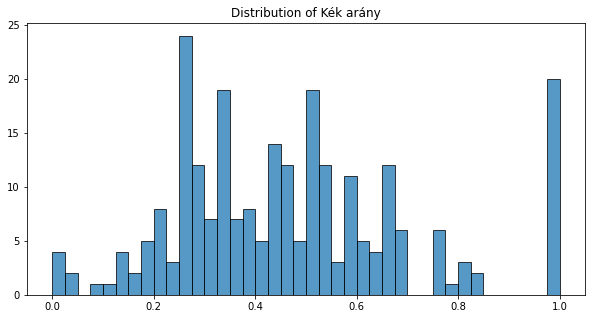

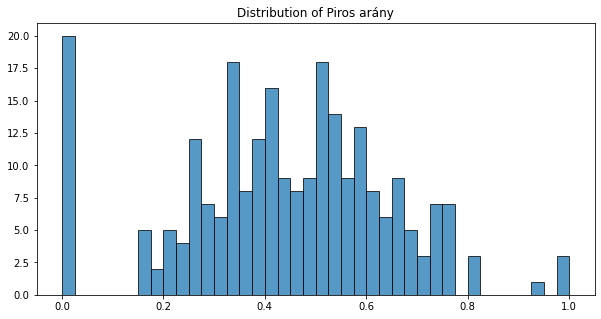

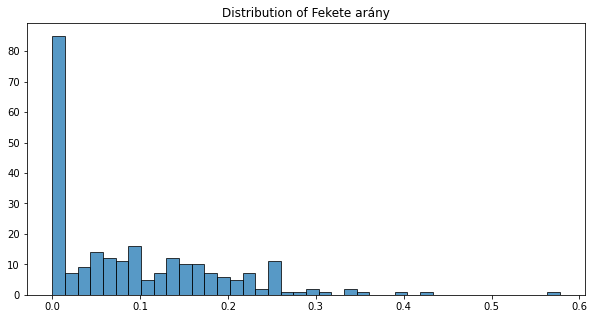

In [91]:
_dist = ['Hegytető', 'Sípályák hossza', 'Szintkülönbség', 'Liftek száma', 
         'Felnőtt napijegy ára', 'Kék arány', 'Piros arány', 'Fekete arány']

for i in _dist:
    vdata.plot_dist(i)

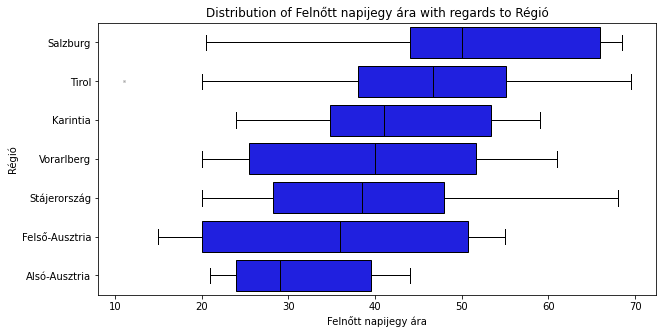

In [93]:
vdata.plot_boxplot('Felnőtt napijegy ára', 'Régió')

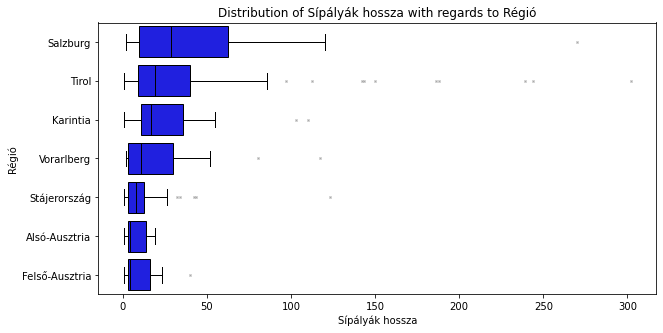

In [94]:
vdata.plot_boxplot('Sípályák hossza', 'Régió')

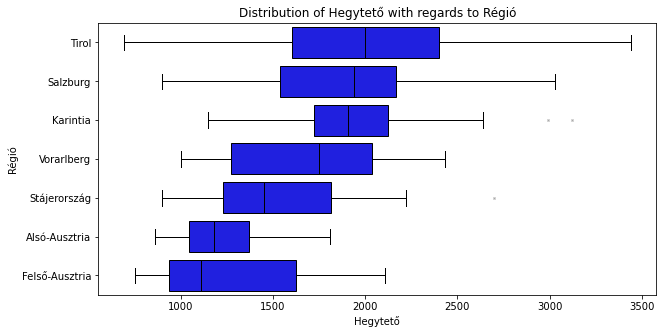

In [95]:
vdata.plot_boxplot('Hegytető', 'Régió')

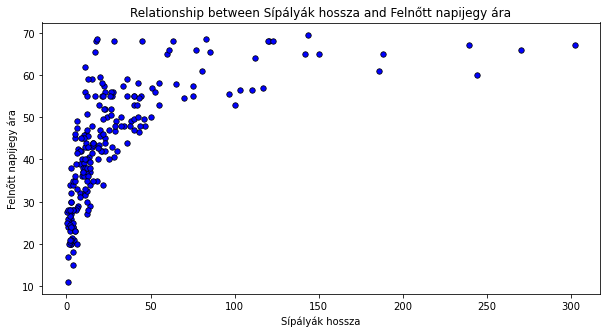

In [96]:
vdata.plot_scatter('Sípályák hossza', 'Felnőtt napijegy ára')

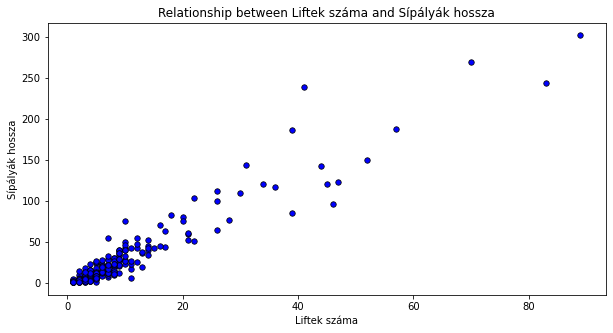

In [97]:
vdata.plot_scatter('Liftek száma', 'Sípályák hossza')

#### Korrelációk

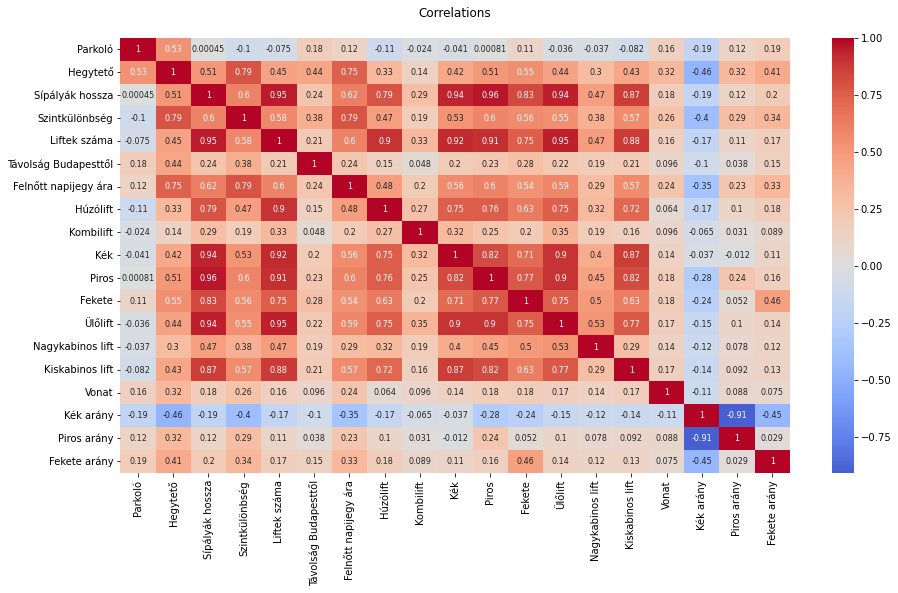

In [98]:
vdata.plot_corr(figsize=(15, 8))

# Modellezés
Felnőtt napijegy ára ~ Síterep információi

In [99]:
data['Szezon eleje'] = pd.to_datetime(data['Szezon eleje'])
data['Szezon vége'] = pd.to_datetime(data['Szezon vége'])

In [100]:
data['Szezon eleje'].dt.month_name().value_counts(dropna = False)

December     168
NaN           65
November       9
October        3
September      2
Name: Szezon eleje, dtype: int64

In [101]:
data['Szezon vége'].dt.month_name().value_counts(dropna = False)

April    100
March     73
NaN       65
May        9
Name: Szezon vége, dtype: int64

In [102]:
df = data.copy()
#df['Szezonhossz (napok)'] = (df['Szezon vége'] - df['Szezon eleje']).dt.days
df.drop(['Link', 'Szezon eleje', 'Szezon vége', 'Kék', 'Piros', 'Fekete', 'Kék arány'], 1, inplace = True)
df.dropna(inplace = True)
df.head()

,Síterep,Régió,Parkoló,Hegytető,Sípályák hossza,Szintkülönbség,Liftek száma,Távolság Budapesttől,Felnőtt napijegy ára,Húzólift,Kombilift,Ülőlift,Nagykabinos lift,Kiskabinos lift,Vonat,Piros arány,Fekete arány
0,Abtenau im Lammertal - Karkogel,Salzburg,712,1200,9.0,488,5,533.0,40.0,4,1,0,0,0,0,0.177778,0.333333
1,Achenkirch - Christlum,Tirol,950,1800,27.0,850,10,709.0,55.0,6,0,4,0,0,0,0.592593,0.185185
2,Aflenz - Bürgeralm,Stájerország,810,1810,14.0,1000,7,364.0,37.0,6,0,1,0,0,0,0.714286,0.142857
3,Alberschwende,Vorarlberg,720,1200,2.5,480,2,863.0,26.0,2,0,0,0,0,0,0.600000,0.000000
4,Altaussee - Loser,Stájerország,850,1800,34.0,950,9,496.0,48.0,5,0,4,0,0,0,0.352941,0.029412


In [103]:
df.shape

(216, 17)

## 1. Lineáris regresszió

In [104]:
import statsmodels.api as sm

In [105]:
df_linreg = pd.get_dummies(df, columns = ['Régió'], prefix_sep = ' = ', drop_first=True)
df_linreg.set_index('Síterep', inplace = True)

df_linreg['Log Sípályák hossza'] = np.log(df_linreg['Sípályák hossza'])
df_linreg['Log Liftek száma'] = np.log(df_linreg['Liftek száma'])

df_linreg.drop(['Liftek száma', 'Sípályák hossza'], 1, inplace = True)

In [106]:
X = df_linreg.drop(['Felnőtt napijegy ára', 'Parkoló'], 1) #parkoló = hegytető - szintkülönbség
X = sm.add_constant(X)
y = df_linreg['Felnőtt napijegy ára']

ols = sm.OLS(y, X.astype(float)).fit()
p_values = ols.pvalues.sort_values()

while len(p_values[p_values >= 0.05]) > 0:
    X.drop(p_values.index[-1], 1, inplace = True)
    ols = sm.OLS(y, X.astype(float)).fit()
    p_values = ols.pvalues.sort_values()

In [107]:
ols.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                             
================================================================================
Dep. Variable:     Felnőtt napijegy ára   R-squared:                       0.799
Model:                              OLS   Adj. R-squared:                  0.793
Method:                   Least Squares   F-statistic:                     138.7
Date:                  Sat, 24 Dec 2022   Prob (F-statistic):           4.91e-70
Time:                          17:02:13   Log-Likelihood:                -700.64
No. Observations:                   216   AIC:                             1415.
Df Residuals:                       209   BIC:                             1439.
Df Model:                             6                                         
Covariance Type:              nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                  11.8224      1.730      6.832      0.000       8.411      15.234
Hegytető                0.0047      0.001      3.380      0.001       0.002       0.008
Szintkülönbség          0.0046      0.002      2.625      0.009       0.001       0.008
Húzólift               -0.5062      0.168     -3.015      0.003      -0.837      -0.175
Régió = Salzburg        4.3773      1.238      3.536      0.001       1.937       6.818
Log Sípályák hossza     3.0206      0.897      3.367      0.001       1.252       4.789
Log Liftek száma        7.1371      1.602      4.455      0.000       3.979      10.295
==============================================================================
Omnibus:                       10.472   Durbin-Watson:                   2.110
Prob(Omnibus):                  0.005   Jarque-Bera (JB):               10.628
Skew:                           0.494   Prob(JB):                      0.00492
Kurtosis:                       3.453   Cond. No.                     9.56e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 9.56e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Regression results:
- Cost of ticket of ski resort that has no lifts, no slopes, no height and is at sea level is: 11.8EUR 
- For every 100m higher mountain, the ticket price increases by 0.0047 * 100 = 4.7EUR 
- For every 100m larger difference between top and bottom of mountain, the ticket price increases by 0.0046 * 100 = 4.6EUR 
- For every added 'húzólift', the ticket price decreases by 0.5EUR 
- Ski resorts in Salzburg region have on average 4.4EUR more expensive tickets 
- 10% increase in length of ski slopes results in 0.3EUR more expensive tix 
- 10% increase in number of ski lifts results in 0.7EUR more expensive tix

### Alul- vagy felülárazott síterepek

In [108]:
yhat = pd.DataFrame({'Tényleges ár' : y, 'Becsült ár LinReg' : ols.predict(X)})
yhat['Árkülönbség LinReg'] = yhat['Tényleges ár'] - yhat['Becsült ár LinReg']

Leginkább túlárazott síterepek

In [109]:
yhat.sort_values('Árkülönbség LinReg').tail(10)

,Tényleges ár,Becsült ár LinReg,Árkülönbség LinReg
Síterep,,,
"Kleinarl, Flachauwinkl - Shuttleberg",68.0,55.579476,12.420524
Ifen,57.5,43.745007,13.754993
Jöchelspitze (Lechtal),46.0,32.115914,13.884086
Ehrwald - Wettersteinbahnen,56.0,41.745486,14.254514
Fageralm,59.0,44.687593,14.312407
Biberwier - Marienberg,56.0,41.431911,14.568089
Fügen - Spieljoch,65.5,50.855993,14.644007
Sportgastein,68.5,49.756803,18.743197
Galsterbergalm,62.0,43.018593,18.981407


Leginkább alulárazott síterepek

In [110]:
yhat.sort_values('Árkülönbség LinReg').head(10)

,Tényleges ár,Becsült ár LinReg,Árkülönbség LinReg
Síterep,,,
Nordkette - Innsbruck,34.0,49.170692,-15.170692
St. Martin am Tennengebirge,23.0,35.536166,-12.536166
Modriach,20.0,31.989883,-11.989883
Weisssee - Uttendorf,44.0,55.952928,-11.952928
Obertauern,53.0,64.428930,-11.428930
Bregenz - Pfänder,20.3,31.518309,-11.218309
Rifflsee,40.0,51.098498,-11.098498
Silvretta Montafon,57.0,67.212891,-10.212891
Grosseck - Speiereck,50.0,59.805021,-9.805021


Murau-val mi a helyzet?

In [111]:
yhat[yhat.index.str.contains('Murau')]

,Tényleges ár,Becsült ár LinReg,Árkülönbség LinReg
Síterep,,,
Kreischberg - Murau,58.0,53.636598,4.363402


In [138]:
alularazottak = yhat[(yhat['Árkülönbség LinReg'] <= -3) & (yhat['Tényleges ár'] >= 45)].sort_values('Árkülönbség LinReg')

In [145]:
data[(data['Felnőtt napijegy ára'].between(45, 60)) & (data['Távolság Budapesttől'] <= 550) & (data['Sípályák hossza'] >= 30)]

,Síterep,Link,Régió,Parkoló,Hegytető,Sípályák hossza,Szintkülönbség,Liftek száma,Szezon eleje,Szezon vége,...,Kék,Piros,Fekete,Ülőlift,Nagykabinos lift,Kiskabinos lift,Vonat,Kék arány,Piros arány,Fekete arány
4,Altaussee - Loser,https://sielok.hu/siterep/loser/,Stájerország,850,1800,34.0,950,9,2022-12-08,2023-04-10,...,21.0,12.0,1.0,4,0,0,0,0.617647,0.352941,0.029412
25,Dachstein West,https://sielok.hu/siterep/dachstein_west/,Salzburg,745,1617,51.0,872,22,2022-12-03,2023-04-02,...,15.0,33.0,3.0,8,0,3,0,0.294118,0.647059,0.058824
64,Grosseck - Speiereck,https://sielok.hu/siterep/grosseck/,Salzburg,1095,2400,50.0,1305,10,2022-12-08,2023-04-10,...,26.0,17.0,7.0,4,0,2,0,0.520000,0.340000,0.140000
72,Hinterstoder,https://sielok.hu/siterep/hinterstoder/,Felső-Ausztria,600,2000,39.9,1400,14,2022-12-10,2023-04-10,...,12.0,18.0,9.9,2,0,2,0,0.300752,0.451128,0.248120
101,Katschberg - Aineck,https://sielok.hu/siterep/katschberg/,Salzburg,1066,2220,70.0,1154,16,2022-12-03,2023-04-10,...,10.0,50.0,10.0,5,0,3,0,0.142857,0.714286,0.142857
112,Kreischberg - Murau,https://sielok.hu/siterep/kreischberg/,Stájerország,868,2118,42.5,1250,12,2022-12-08,2023-04-10,...,17.5,16.0,9.0,3,0,3,0,0.411765,0.376471,0.211765
148,Obertauern,https://sielok.hu/siterep/obertauern/,Salzburg,1630,2313,100.0,683,26,2022-11-25,2023-05-01,...,61.0,35.0,4.0,17,0,1,0,0.610000,0.350000,0.040000
170,Riesneralm,https://sielok.hu/siterep/riesneralm/,Stájerország,973,1820,32.2,847,7,2022-12-02,2023-04-10,...,20.2,9.0,3.0,3,0,0,0,0.627329,0.279503,0.093168
220,Tauplitz,https://sielok.hu/siterep/tauplitz/,Stájerország,896,1965,43.5,1069,17,2022-12-02,2023-04-10,...,18.5,19.0,6.0,4,0,1,0,0.425287,0.436782,0.137931
225,Turracher Höhe,https://sielok.hu/siterep/turrach/,Karintia,1400,2205,43.0,805,15,2022-12-03,2023-04-23,...,14.5,25.0,3.5,5,0,0,0,0.337209,0.581395,0.081395


## 2. Regressziós fa

In [114]:
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

In [115]:
df_rf = pd.get_dummies(df, columns = ['Régió'], prefix_sep = ' = ', drop_first=True)
df_rf.set_index('Síterep', inplace = True)

X = df_rf.drop(['Felnőtt napijegy ára'], 1)
y = df_rf['Felnőtt napijegy ára']

In [116]:
DT_params = {'max_depth' : [5],
             'min_samples_split' : [10],
             'min_samples_leaf' : [5],
             'max_features' : [2/3]}

DT = DecisionTreeRegressor(random_state = 20202020)
GRID_DT = GridSearchCV(DT, param_grid = DT_params, cv = 5, scoring = 'neg_root_mean_squared_error', n_jobs = -1)
GRID_DT.fit(X, y)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(random_state=20202020),
             n_jobs=-1,
             param_grid={'max_depth': [5], 'max_features': [0.6666666666666666],
                         'min_samples_leaf': [5], 'min_samples_split': [10]},
             scoring='neg_root_mean_squared_error')

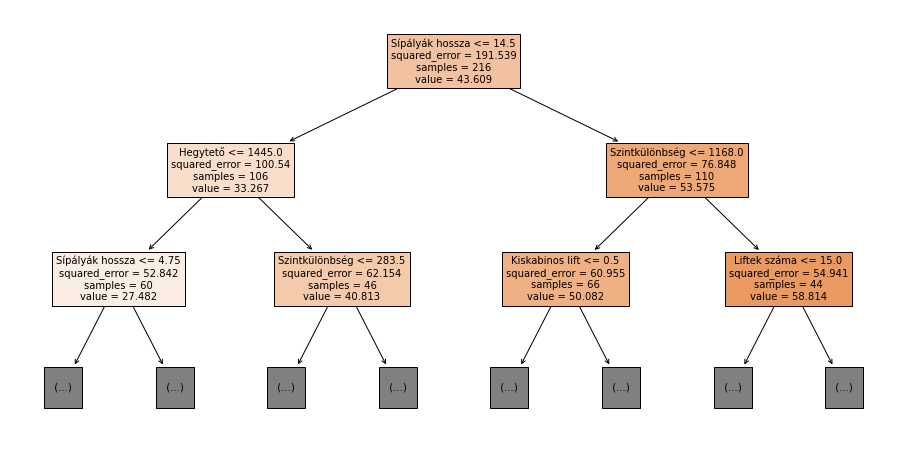

In [117]:
plt.figure(figsize = (16, 8))
plot_tree(GRID_DT.best_estimator_, feature_names = X.columns, 
          filled = True, fontsize = 10, max_depth = 2)
plt.show()

In [118]:
r2_score(y, GRID_DT.best_estimator_.predict(X))

0.8981262314847833

A lineáris regresszióhoz képest (0.8 r2) a regressziós döntési fa 0.9 körüli r2-el becsül

In [119]:
yhat['Becsült ár Reg Fa'] = GRID_DT.best_estimator_.predict(X)
yhat['Árkülönbség Reg Fa'] = yhat['Tényleges ár'] - yhat['Becsült ár Reg Fa']

In [120]:
yhat[yhat.index.str.contains('Murau')]

,Tényleges ár,Becsült ár LinReg,Árkülönbség LinReg,Becsült ár Reg Fa,Árkülönbség Reg Fa
Síterep,,,,,
Kreischberg - Murau,58.0,53.636598,4.363402,56.8,1.2


## Klaszterezés
Vannak-e adataiban hasonlító síterepek, síterepcsoportok? Mennyire választhatók klaszterekbe az osztrák síterepek?

In [121]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

def return_scaled_dataframe(dataframe, scaler = StandardScaler()):
    
    to_scale_features = dataframe.select_dtypes([np.number]).columns
    scaled_features = dataframe[to_scale_features].copy()
    scaled_columns = scaled_features.columns
    scaled_features[scaled_columns] = scaler.fit_transform(scaled_features)

    return scaled_features


def clustering_metrics(data):
    
    Sum_of_squared_distances = []
    Silhouette_value = []
    Calinski_Harabasz = []
    Davies_Bouldin = []

    K = range(2, 20 + 1)

    for k in K:

        km = KMeans(n_clusters = k, n_init = 20, max_iter = 500, random_state = 20202020)
        km = km.fit(data)
        labels = km.labels_

        Sum_of_squared_distances.append(km.inertia_)
        Silhouette_value.append(silhouette_score(data, labels, metric = 'euclidean'))
        Calinski_Harabasz.append(calinski_harabasz_score(data, labels))
        Davies_Bouldin.append(davies_bouldin_score(data, labels))

    fig, ax = plt.subplots(ncols = 2, nrows = 2, figsize = (12, 7))

    sns.pointplot(x = list(K), y = Sum_of_squared_distances, markers = 'x', s = 10, ax = ax[0, 0])
    sns.pointplot(x = list(K), y = Silhouette_value, markers = 'x', s = 10, ax = ax[1, 0])
    sns.pointplot(x = list(K), y = Calinski_Harabasz, markers = 'x', s = 10, ax = ax[0, 1])
    sns.pointplot(x = list(K), y = Davies_Bouldin, markers = 'x', s = 10, ax = ax[1, 1])

    ax[0, 0].title.set_text('Sum of squared distances ("elbow")')
    ax[1, 0].title.set_text('Silhouette value')
    ax[0, 1].title.set_text('Calinski-Harabasz')
    ax[1, 1].title.set_text('Davies-Bouldin')

    plt.show()

def plot_clusters(data, x, y, hover_data = []):
    
    fig = px.scatter(data, x = x, y = y, color = 'clusters', hover_data = hover_data,
                     title = 'Clusters plotted via reduced dimensionality', 
                     width = 750, height = 550)
    fig.update_layout(showlegend=True)
    fig.show()

def show_diff_between_clusters(data, height = 1450):
    
    fig = px.box(data_frame = data, y = 'value', x = 'clusters', color = 'clusters',
                 facet_row_spacing = 0.05, facet_col_spacing = 0.05,
                  title = 'Distribution differences across clusters', facet_col = 'stat', facet_col_wrap = 3,
                  width = 950, height = height)

    fig.update_xaxes(visible = True, showticklabels = True, title = None, matches = None, type = 'category', categoryorder='category ascending')
    fig.update_yaxes(visible = True, showticklabels = True, title = None, matches = None)
    fig.for_each_annotation(lambda a: a.update(text = a.text.split('=')[-1]))
    fig.update_traces(marker = {'size' : 4}, line = {'width' : 1})
    fig.update_layout(showlegend=False)
    fig.show()

In [122]:
df_cluster = data.drop(['Link', 'Régió', 'Szezon eleje', 'Szezon vége', 'Távolság Budapesttől', 'Húzólift', 'Parkoló', 
                        'Piros', 'Kék', 'Fekete', 'Vonat', 'Kombilift', 'Nagykabinos lift'], 1).copy() #'Felnőtt napijegy ára'
df_cluster.set_index('Síterep', inplace = True)

In [123]:
df_cluster_scaled = return_scaled_dataframe(df_cluster)

In [124]:
df_cluster_scaled.dropna(inplace = True)

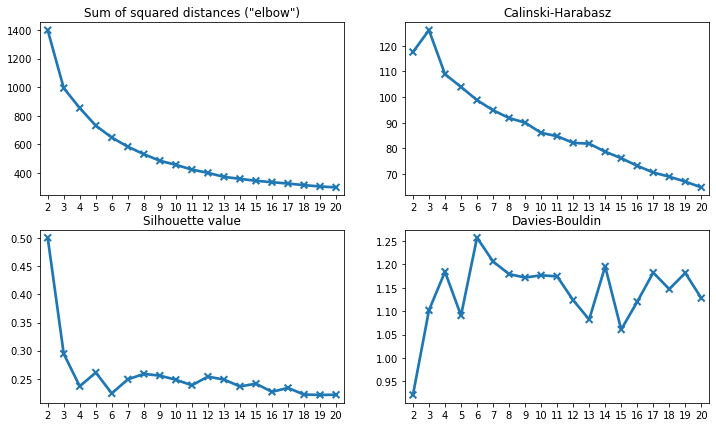

In [125]:
clustering_metrics(df_cluster_scaled)

In [126]:
pca = PCA(random_state = 20202020)
pca.fit(df_cluster_scaled)

comp = pd.DataFrame(pca.components_, columns = df_cluster_scaled.columns)
exp_var = pd.DataFrame(pca.explained_variance_ratio_ * 100, columns = ['Explained variance % '])

pca_results = pd.concat([exp_var, comp], 1)
pca_results.head()

,Explained variance %,Hegytető,Sípályák hossza,Szintkülönbség,Liftek száma,Felnőtt napijegy ára,Ülőlift,Kiskabinos lift,Kék arány,Piros arány,Fekete arány
0,55.915847,0.306015,0.407286,0.340017,0.398679,0.346310,0.388196,0.377272,-0.151609,0.104279,0.138187
1,19.451105,-0.307360,0.224891,-0.201481,0.260523,-0.153410,0.259623,0.242081,0.540632,-0.461929,-0.302132
2,10.050544,0.301595,-0.111025,0.245715,-0.153875,0.232296,-0.148683,-0.122932,0.333507,-0.605961,0.493016
3,6.862031,-0.300445,0.145292,-0.354836,0.150030,-0.323066,0.126378,0.058640,-0.255491,-0.063718,0.739654
4,2.757178,-0.101402,-0.116888,0.211157,-0.081585,-0.180351,-0.523119,0.785209,-0.018465,0.000959,0.041679


In [127]:
CLUST_NUMBER = 3

PCAs = pd.DataFrame(pca.transform(df_cluster_scaled))[[0, 1]]
PCAs.columns = ['PCA_1', 'PCA_2']

km = KMeans(n_clusters = CLUST_NUMBER, n_init = 20, max_iter = 500, random_state = 20202020).fit(df_cluster_scaled)
km = pd.DataFrame(km.predict(df_cluster_scaled), columns = ['clusters'])
kmeans_results = pd.concat([pd.Series(df_cluster_scaled.index), PCAs, km], 1)
kmeans_results.clusters = kmeans_results.clusters.astype('object')

kmeans_results.head(3)

,Síterep,PCA_1,PCA_2,clusters
0,Abtenau im Lammertal - Karkogel,-1.234031,-0.047715,0
1,Achenkirch - Christlum,0.516185,-1.389529,2
2,Aflenz - Bürgeralm,-0.202163,-1.856722,2


In [128]:
kmeans_results.clusters.value_counts()

2    109
0     92
1     16
Name: clusters, dtype: int64

In [129]:
plot_clusters(kmeans_results, 'PCA_1', 'PCA_2', hover_data = ['Síterep'])

In [130]:
kmeans_results[kmeans_results.Síterep.str.contains('Murau')]

,Síterep,PCA_1,PCA_2,clusters
99,Kreischberg - Murau,1.359978,-0.619525,2


In [131]:
kmeans_results[kmeans_results.PCA_1 > 8]

,Síterep,PCA_1,PCA_2,clusters
153,Saalbach Hinterglemm Leogang Fieberbrunn,9.767483,5.203330,1
172,Ski Arlberg - St. Anton - Lech - Zürs - Warth,10.826396,4.424504,1
174,SkiWelt Wilder Kaiser - Brixental,8.965347,4.886456,1


In [132]:
cluster_exploration = pd.concat([df_cluster.reset_index(), km], 1)
cluster_exploration_melt = pd.melt(cluster_exploration, id_vars = ['Síterep', 'clusters'], var_name = 'stat', value_name = 'value')
cluster_exploration_melt.dropna(inplace = True)

show_diff_between_clusters(cluster_exploration_melt, height = 950)